In [ ]:
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import torch
import pyarrow
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Intro

In this notebook, I use a sentence transformer, PCA and K-means clustering to turn the free text chief complaint into ca category varibale that can be used for analysis 

# Data

Data comes from the first [notebook](/1_mimic_data.ipynb) in this repo, which must be run first 

In [5]:
file_path = 'ed_join_cc.parquet'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}. Have you run the previous notebook?")
else:
    print(f"File found: {file_path}")

File found: ed_join_cc.parquet


In [2]:
data = pd.read_parquet('ed_join_cc.parquet')
data = data[['stay_id', 'chiefcomplaint']]

# Create Category

Clean the text

In [3]:
# Common abbreviations from MIMIC
abbreviation_dict = {
    "r/o": "rule out",
    "l": "left",
    "L": "left",
    "r": "right",
    "R": "right",
    "rt.": "right",
    "s/p": "status post",
    "mvc": "motor vehicle collision",
    "ha": "headache",
    "h/a": "headache",
    "n/v": "nausea and vomiting",
    "nv": "nausea and vomiting",
    "abd": "abdomen",
    "etoh": "alcohol intoxication",
    "lbp": "lower back pain",
    "ili": "influenza-like illness",
    "post op": "post operative",
    "rle": "right lower extremity",
    "lle": "left lower extremity",
    "eval": "evaluation",
    "ped": "pedestrian",
    "b": "bilateral",
    "dvt": "deep vein thrombosis",
    "rx": "prescription",
    "rue": "right upper extremity",
    "lue": "left upper extremity",
    "ruq": "right upper quadrant",
    "rlq": "right lower quadrant",
    "luq": "left upper quadrant",
    "llq": "left lower quadrant",
    "fx": "fracture",
    "sz": "seizure",
    "inj": "injury",
    "sah": "subarachnoid hemorrhage",
    "si": "suicidal ideation",
    "hi": "homicidal ideation",
    "sob": "shortness of breath"
}
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    # Replace abbreviations using word boundaries
    for abbr, full_form in abbreviation_dict.items():
        pattern = r'\b' + re.escape(abbr) + r'\b'
        text = re.sub(pattern, full_form, text)
    # Normalize spacing and remove non-alpha characters
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove selected terms
    text = re.sub(r'\b(left|right|status post|motor)\b', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

data['cc_cleaned'] = data['chiefcomplaint'].apply(clean_text)

Create embeddings using a sentence transformer. The model is [this](https://huggingface.co/pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb) one 

In [4]:
model_name = SentenceTransformer('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')
embeddings = model_name.encode(data['cc_cleaned'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 13273/13273 [08:51<00:00, 24.97it/s]


Reduce the dimensions and cluster.

First, pick n for PCA

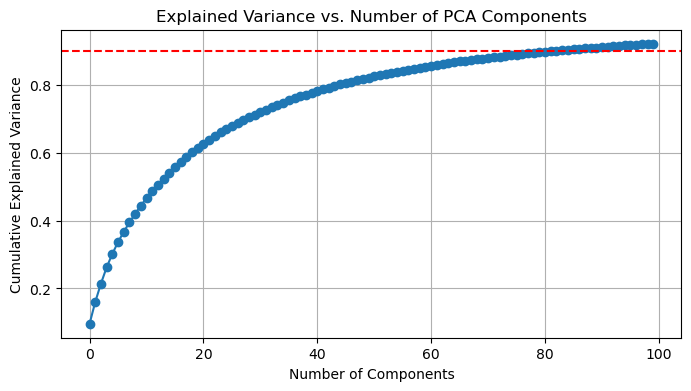

In [5]:
X = embeddings
# Compute PCA without reducing dimensions first
pca_full = PCA(n_components=100)  
pca_full.fit(X)

# Plot cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')  # commonly used threshold
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.grid(True)
plt.show()

In [6]:
# Reduce dimensions to 80 before clustering
pca = PCA(n_components=80)
X_reduced = pca.fit_transform(X)

Now Get the elbow for K

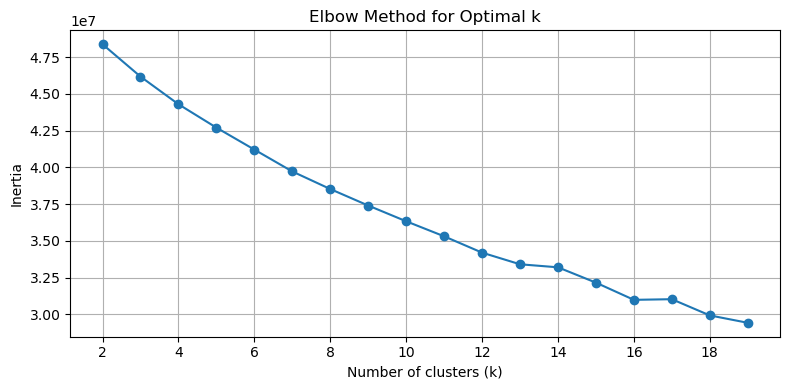

In [17]:
inertias = []
k_range = range(2, 20)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_reduced)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Force x-axis ticks (req ticker)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [18]:
# Cluster using K-means with k=12
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_reduced)
# Add back onto the original data
data['cluster'] = cluster_labels

# Analyze

How many per cluster in order

In [8]:
data['cluster'].value_counts()

cluster
7     77687
5     51399
4     48899
2     48187
0     36265
3     36012
6     30918
1     29705
9     23082
11    18052
8     12848
10    11653
Name: count, dtype: int64

In [9]:
data['cluster'].isnull().sum()

0

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

for cluster_id in range(kmeans.n_clusters):
    cluster_data = data[data['cluster'] == cluster_id]['cc_cleaned']
    print(f"\nCluster {cluster_id} (size={len(cluster_data)}):")

    
    # Use CountVectorizer to extract n-grams
    vectorizer = CountVectorizer(ngram_range=(2,3), max_features=20)
    X_ngrams = vectorizer.fit_transform(cluster_data)
    ngram_counts = X_ngrams.sum(axis=0)
    ngram_freq = [(ngram, ngram_counts[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    ngram_freq_sorted = sorted(ngram_freq, key=lambda x: -x[1])
    
    print("  Most common bigrams/trigrams:")
    for ngram, freq in ngram_freq_sorted[:10]:
        print(f"    {ngram}: {freq}")



Cluster 0 (size=36265):
  Most common bigrams/trigrams:
    back pain: 14977
    lower back: 5213
    lower back pain: 5204
    shoulder pain: 3377
    arm pain: 3188
    neck pain: 2669
    pain fall: 1354
    hand pain: 1063
    chest pain: 1041
    wrist pain: 977

Cluster 1 (size=29705):
  Most common bigrams/trigrams:
    like illness: 5047
    influenza like: 5046
    influenza like illness: 5046
    sore throat: 3927
    allergic reaction: 2394
    asthma exacerbation: 1023
    cough fever: 577
    cough influenza: 503
    cough influenza like: 501
    fever influenza: 499

Cluster 2 (size=48187):
  Most common bigrams/trigrams:
    vehicle collision: 5576
    mental status: 4540
    altered mental: 4427
    altered mental status: 4419
    head injury: 2113
    eye pain: 2007
    ear pain: 1489
    visual changes: 1390
    neck pain: 1224
    facial swelling: 940

Cluster 3 (size=36012):
  Most common bigrams/trigrams:
    chest pain: 25556
    pain dyspnea: 2610
    chest pain

# Save

In [29]:
data.to_parquet('chiefcomp_clustered.parquet', index=False)

In [12]:
# Save as pickle
import pickle

with open('chiefcomp_data.pkl', 'wb') as f:
    pickle.dump({'data': data, 'embeddings': embeddings}, f)